In [3]:
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
import trame
from scipy.spatial import Delaunay

In [9]:
# Enable notebook rendering
pv.set_jupyter_backend('static')

### 1. Functions to Create the Circles and Extrude to Cylinders

In [37]:
# Create a circle in the x-z plane
def create_circle(radius, n_points=100):
    theta = np.linspace(0, 2 * np.pi, n_points)
    x = radius * np.cos(theta)
    z = radius * np.sin(theta)
    points = np.vstack((x, np.zeros(n_points), z)).T
    lines = np.column_stack((np.full(n_points, 2), np.arange(n_points), np.roll(np.arange(n_points), -1)))
    lines = lines.flatten()
    circle = pv.PolyData(points)
    circle.lines = lines
    return circle

# Extrude the circles in the y direction to create cylinders
def extrude_circle(circle, extrusion_length_pos, extrusion_length_neg):
    extruded_pos = circle.extrude([0, extrusion_length_pos, 0])
    extruded_neg = circle.extrude([0, extrusion_length_neg, 0])
    extruded = extruded_pos + extruded_neg
    return extruded



### 2. Load the Mesh and Compute Parameters for the Cylinders

In [38]:
# Load the intraoral mesh
intraoral_mesh = pv.read(r'D:\sunny\Codes\DPS\data\Origin_seg\000101_origin.ply')

# Calculate the radii: 
# the outer radius is the maximum distance from the origin
# the inner radius is the minimum distance
distances = np.linalg.norm(intraoral_mesh.points[:, [0, 2]], axis=1)
outer_radius = np.max(distances)
inner_radius = np.min(distances)
n_points = 100

# Calculate the extrusion length
y_min = np.min(intraoral_mesh.points[:, 1])
y_max = np.max(intraoral_mesh.points[:, 1])
extrusion_length_pos = y_max
extrusion_length_neg = y_min
print(f'Extrusion length: {extrusion_length_pos} (pos), {extrusion_length_neg} (neg)')

# Create the circles
circle_outer = create_circle(outer_radius, n_points)
circle_inner = create_circle(inner_radius, n_points)
# Extrude the circles to create cylinders
cylinder_outer = extrude_circle(circle_outer, extrusion_length_pos, extrusion_length_neg)
cylinder_inner = extrude_circle(circle_inner, extrusion_length_pos, extrusion_length_neg)


Extrusion length: 10.682730674743652 (pos), -10.682730674743652 (neg)


d:\Users\sunny\anaconda3\envs\env_dps\lib\site-packages\pyvista\core\filters\poly_data.py:2997: PyVistaFutureWarning: The default value of the ``capping`` keyword argument will change in a future version to ``True`` to match the behavior of VTK. We recommend passing the keyword explicitly to prevent future surprises.
  warnings.warn(


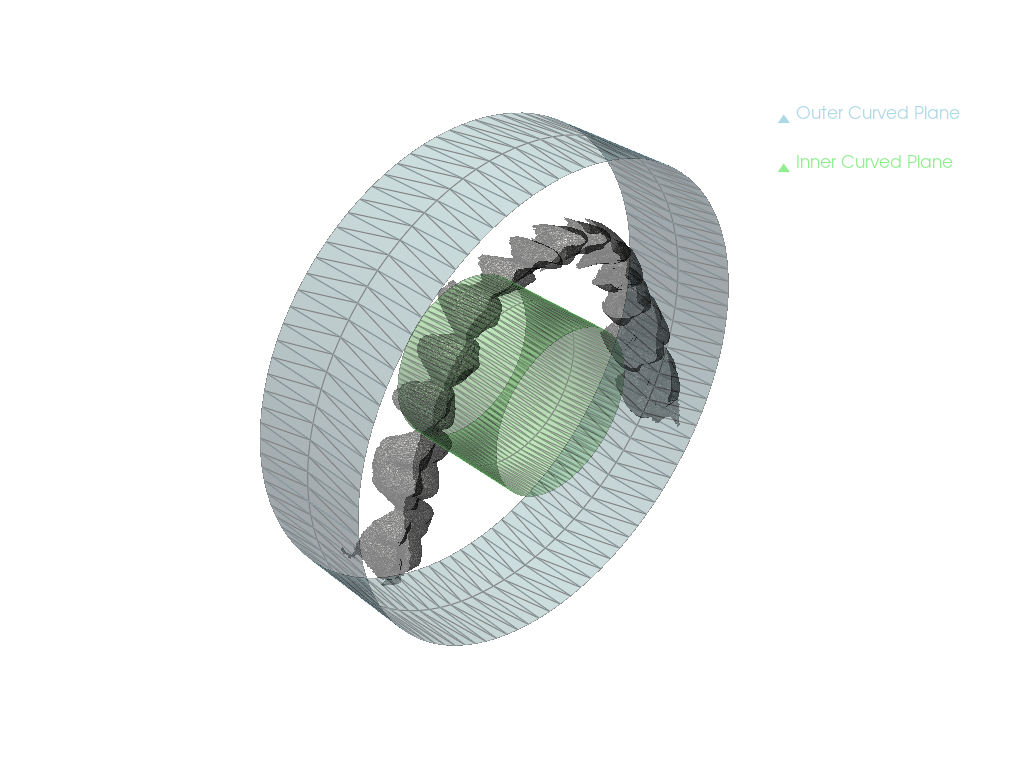

In [39]:
# Visualize the splines and curved planes
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(intraoral_mesh, color='white', opacity=0.5, show_edges=True, label='Original Mesh')
plotter.add_mesh(cylinder_outer, color='lightblue', opacity=0.5, show_edges=True, label='Outer Curved Plane')
plotter.add_mesh(cylinder_inner, color='lightgreen', opacity=0.5, show_edges=True, label='Inner Curved Plane')
plotter.add_legend()
plotter.show()

### 3. Filter Vertices by normals

In [40]:
# Function to calculate vertex normals
def calculate_vertex_normals(mesh):
    mesh.compute_normals(cell_normals=False, point_normals=True, inplace=True)
    return mesh.point_normals

# Function to check if a vertex is outward-facing or inward-facing
def is_outward_facing(normal, point):
    return np.dot(normal, point) > 0

def is_inward_facing(normal, point):
    return np.dot(normal, point) < 0


# Calculate vertex normals
vertex_normals = calculate_vertex_normals(intraoral_mesh)

In [41]:
# Filter outward-facing vertices for the outer cylinder
outward_facing_mask = np.array([is_outward_facing(normal, point) for normal, point in zip(vertex_normals, intraoral_mesh.points)])
outward_facing_mesh = intraoral_mesh.extract_points(outward_facing_mask)

# Filter inward-facing vertices for the inner cylinder
inward_facing_mask = np.array([is_inward_facing(normal, point) for normal, point in zip(vertex_normals, intraoral_mesh.points)])
inward_facing_mesh = intraoral_mesh.extract_points(inward_facing_mask)

### 4. Define the Projection Function with Color Information

In [42]:
# # Function to project a mesh onto a cylinder and embed color information
# def project_mesh_onto_cylinder(mesh, radius, y_min, y_max, is_inner=False):
#     projected_uv = []
#     colors = []
#     extrusion_length = y_max - y_min
#     for point, color in zip(mesh.points, mesh.point_data['RGB']):
#         x, y, z = point
#         theta = np.arctan2(z, x)
#         r = np.sqrt(x**2 + z**2)
#         if is_inner:
#             if r>=radius: # For inner cylinder, we project if the point is outside the radius
#                 uv = [theta / (2 * np.pi), (y - y_min) / extrusion_length]
#                 projected_uv.append(uv)
#                 colors.append(color / 255.0)
#         else: 
#             if r <= radius: # For outer cylinder, we project if the point is inside the radius 
#                 uv = [theta / (2 * np.pi), (y - y_min) / extrusion_length]
#                 projected_uv.append(uv)
#                 colors.append(color / 255.0)  # Normalize color to [0, 1]
#     projected_uv = np.array(projected_uv)
#     colors = np.array(colors)
#     print(f'Projected UV: {projected_uv.shape}')
#     print(f'Colors: {colors.shape}')
#     return projected_uv, colors

In [64]:
def project_mesh_onto_cylinder(mesh, radius, extrusion_length_neg, extrusion_length_pos, inward_facing):
    uv_coords = []
    colors = []
    for i in range(mesh.n_points):
        point = mesh.points[i]
        if inward_facing and point[1] < extrusion_length_neg:
            continue
        if not inward_facing and point[1] > extrusion_length_pos:
            continue
        theta = np.arctan2(point[2], point[0])
        # if inward_facing:
        #     theta += np.pi  # Flip the angle for inward-facing projection
        if theta < -np.pi / 2:
            theta += 2 * np.pi  # Ensure the angle is in [0, 2*pi]
        y = point[1]
        uv_coords.append([theta, y])
        colors.append(mesh.point_data['RGB'][i] / 255.0)
    return np.array(uv_coords), np.array(colors)

# # Calculate radii for the outer and inner cylinders
# outer_radius = np.max(np.linalg.norm(intraoral_mesh.points[:, [0, 2]], axis=1))
# inner_radius = np.percentile(np.linalg.norm(intraoral_mesh.points[:, [0, 2]], axis=1), 20)
# extrusion_length_neg = y_min
# extrusion_length_pos = y_max

# # Project the mesh onto the cylindrical screens
# projected_outer_uv, colors_outer = project_mesh_onto_cylinder(outward_facing_mesh, outer_radius, extrusion_length_neg, extrusion_length_pos, False)
# projected_inner_uv, colors_inner = project_mesh_onto_cylinder(inward_facing_mesh, inner_radius, extrusion_length_neg, extrusion_length_pos, True)


### 5. Apply Projections

In [65]:
# Project the mesh onto the curved planes
projected_outer_uv, colors_outer = project_mesh_onto_cylinder(outward_facing_mesh, outer_radius, extrusion_length_neg, extrusion_length_pos, False)
projected_inner_uv, colors_inner = project_mesh_onto_cylinder(inward_facing_mesh, inner_radius, extrusion_length_neg, extrusion_length_pos, True)


#### 5.1. Visualization: Points

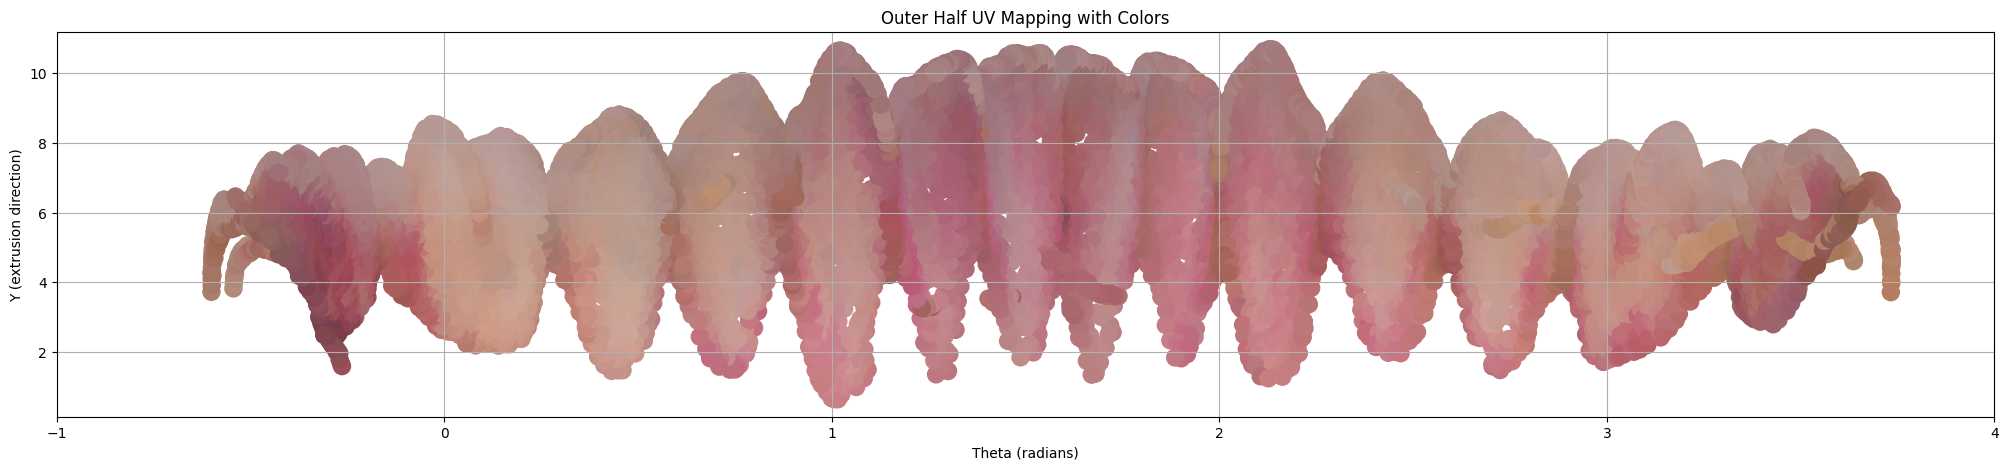

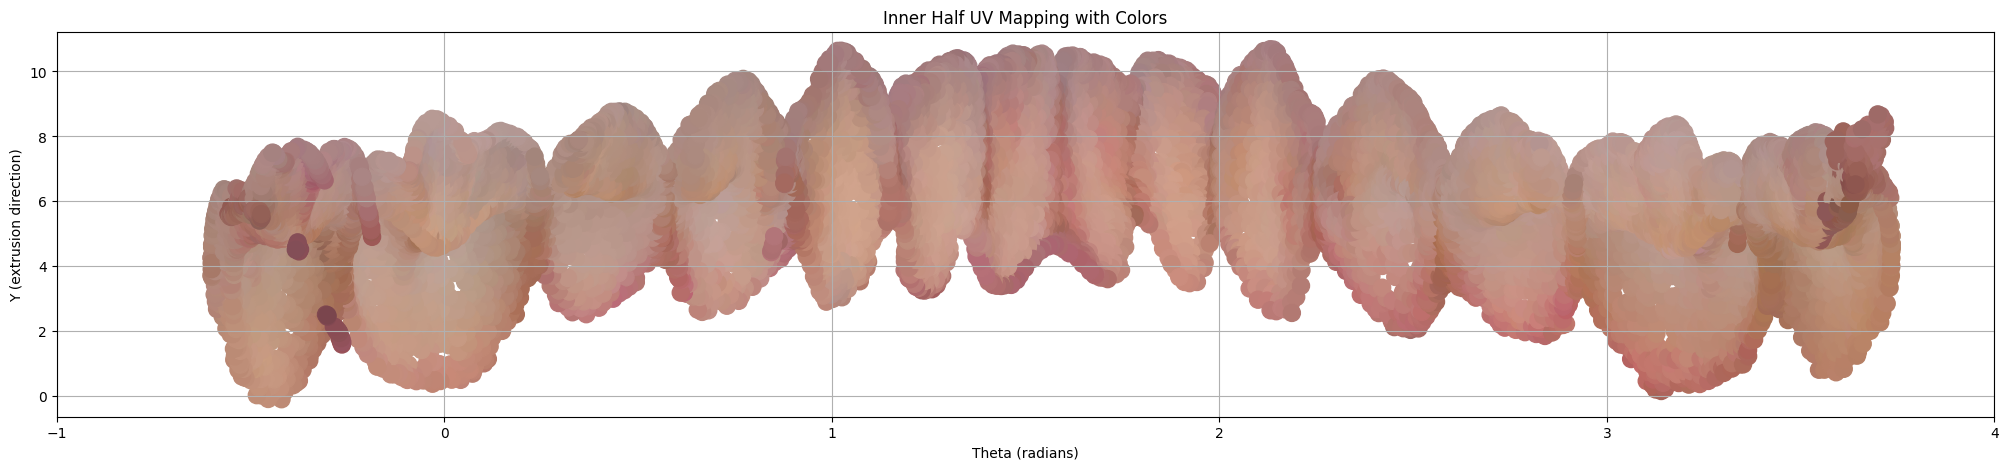

In [73]:
# Visualize the projections with color information
def visualize_uv_mapping_with_colors(uv_coords, colors, title):
    if uv_coords.size == 0:
        print(f'No UV coordinates to plot for {title}')
        return
    plt.figure(figsize=(25, 5))
    plt.scatter(uv_coords[:, 0], uv_coords[:, 1], c=colors, marker='o', s=150) #s:marker size
    plt.title(title)
    plt.xlabel('Theta (radians)')
    plt.ylabel('Y (extrusion direction)')
    # plt.xlim(-np.pi / 2, 3 * np.pi / 2)  # Set x-axis limits to the new range
    plt.xlim(-1,4)
    plt.grid(True)
    plt.show()


# Visualize the projections with color information
visualize_uv_mapping_with_colors(projected_outer_uv, colors_outer, 'Outer Half UV Mapping with Colors')
visualize_uv_mapping_with_colors(projected_inner_uv, colors_inner, 'Inner Half UV Mapping with Colors')


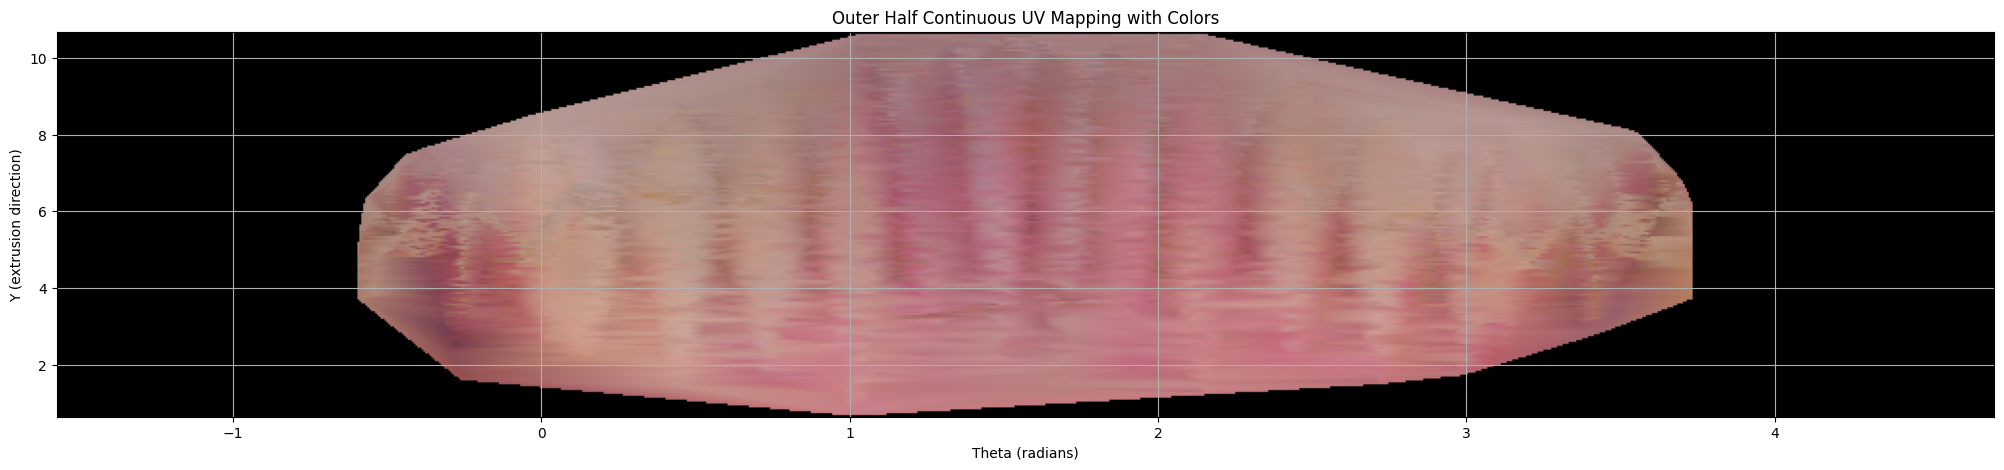

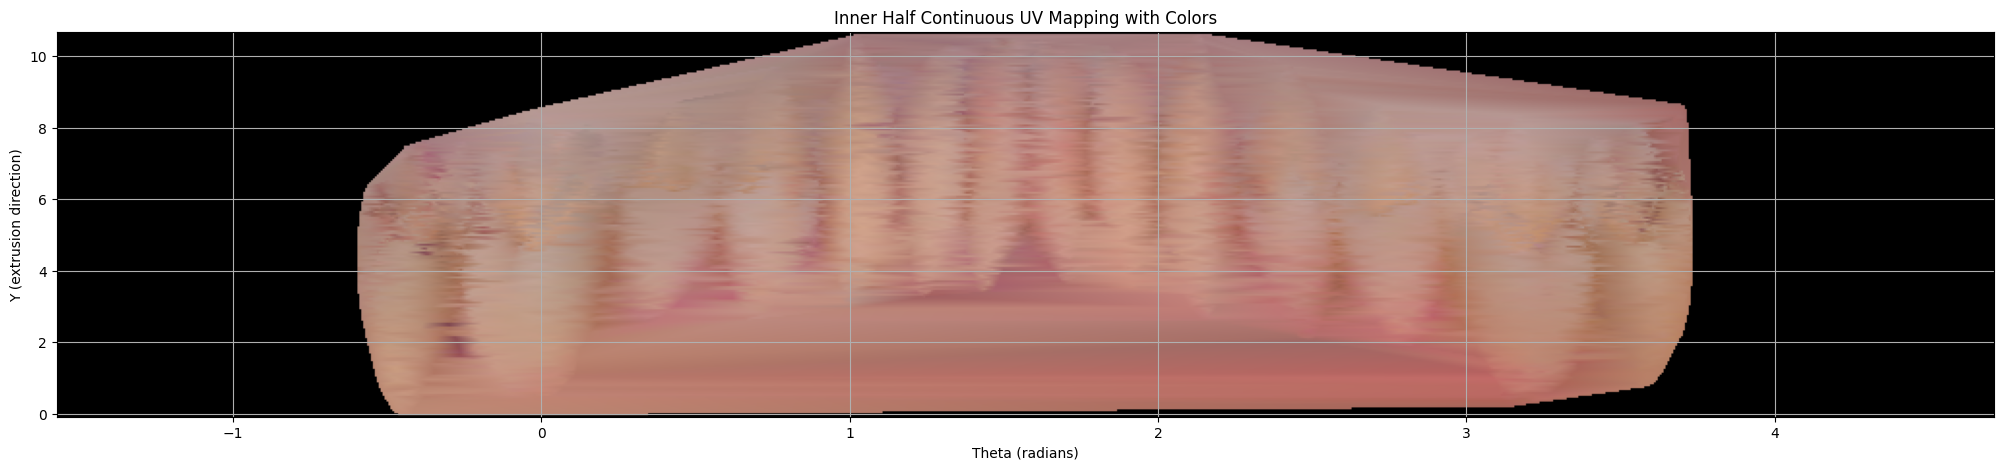

In [68]:
from scipy.interpolate import griddata

def visualize_continuous_uv_mapping_with_interpolation(uv_coords, colors, title, resolution_theta=1000):
    if uv_coords.size == 0:
        print(f'No UV coordinates to plot for {title}')
        return
    
    # Define the aspect ratio and calculate resolution for y axis
    aspect_ratio = 25 / 5
    resolution_y = int(resolution_theta / aspect_ratio)
    
    # Create a high-resolution grid
    theta_min, theta_max = -np.pi / 2, 3 * np.pi / 2
    y_min, y_max = np.min(uv_coords[:, 1]), np.max(uv_coords[:, 1])
    theta_range = np.linspace(theta_min, theta_max, resolution_theta)
    y_range = np.linspace(y_min, y_max, resolution_y)
    theta_grid, y_grid = np.meshgrid(theta_range, y_range)
    
    # Interpolate the colors onto the grid
    grid_r = griddata(uv_coords, colors[:, 0], (theta_grid, y_grid), method='linear', fill_value=0)
    grid_g = griddata(uv_coords, colors[:, 1], (theta_grid, y_grid), method='linear', fill_value=0)
    grid_b = griddata(uv_coords, colors[:, 2], (theta_grid, y_grid), method='linear', fill_value=0)
    
    # Stack the interpolated color channels
    image = np.stack((grid_r, grid_g, grid_b), axis=-1)
    
    # Plot the image
    plt.figure(figsize=(25, 5))
    plt.imshow(image, extent=[theta_min, theta_max, y_min, y_max], origin='lower', aspect='auto')
    plt.title(title)
    plt.xlabel('Theta (radians)')
    plt.ylabel('Y (extrusion direction)')
    plt.grid(True)
    plt.show()

# Visualize the continuous and filled-in projections with color information
visualize_continuous_uv_mapping_with_interpolation(projected_outer_uv, colors_outer, 'Outer Half Continuous UV Mapping with Colors')
visualize_continuous_uv_mapping_with_interpolation(projected_inner_uv, colors_inner, 'Inner Half Continuous UV Mapping with Colors')


#### 5.2. Visualization: Delaunay Triangularization

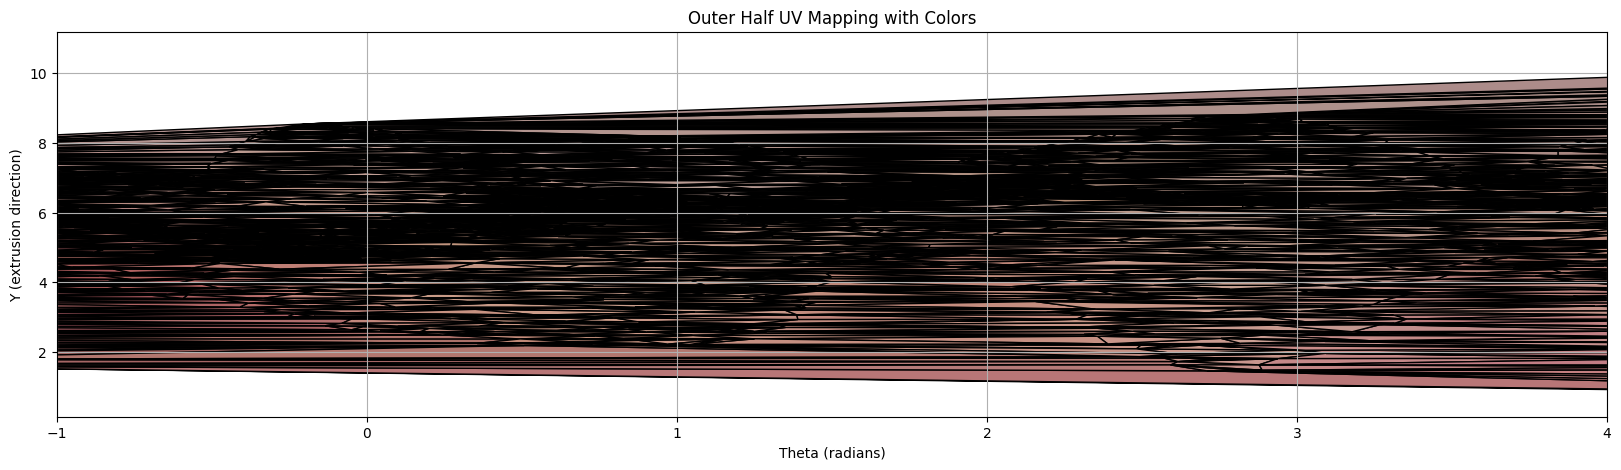

No UV coordinates to plot for Inner Half UV Mapping with Colors


In [56]:
def visualize_uv_mapping_with_colors(mesh, uv_coords, colors, title):
    if uv_coords.size == 0:
        print(f'No UV coordinates to plot for {title}')
        return
    plt.figure(figsize=(20, 5))
    
    # Perform Delaunay triangulation
    tri = Delaunay(uv_coords)
    
    # Plot triangles with mean colors
    for simplex in tri.simplices:
        pts = uv_coords[simplex]
        tri_color = np.mean(colors[simplex], axis=0)
        plt.fill(pts[:, 0] * (2 * np.pi), pts[:, 1], facecolor=tri_color, edgecolor='k')
    
    plt.title(title)
    plt.xlabel('Theta (radians)')
    plt.ylabel('Y (extrusion direction)')
    plt.xlim(-1, 4)
    plt.grid(True)
    plt.show()

# Visualize the projections with color information
visualize_uv_mapping_with_colors(intraoral_mesh, projected_outer_uv, colors_outer, 'Outer Half UV Mapping with Colors')
visualize_uv_mapping_with_colors(intraoral_mesh, projected_inner_uv, colors_inner, 'Inner Half UV Mapping with Colors')


#### 5.3. Visualization: Pixalize image grid

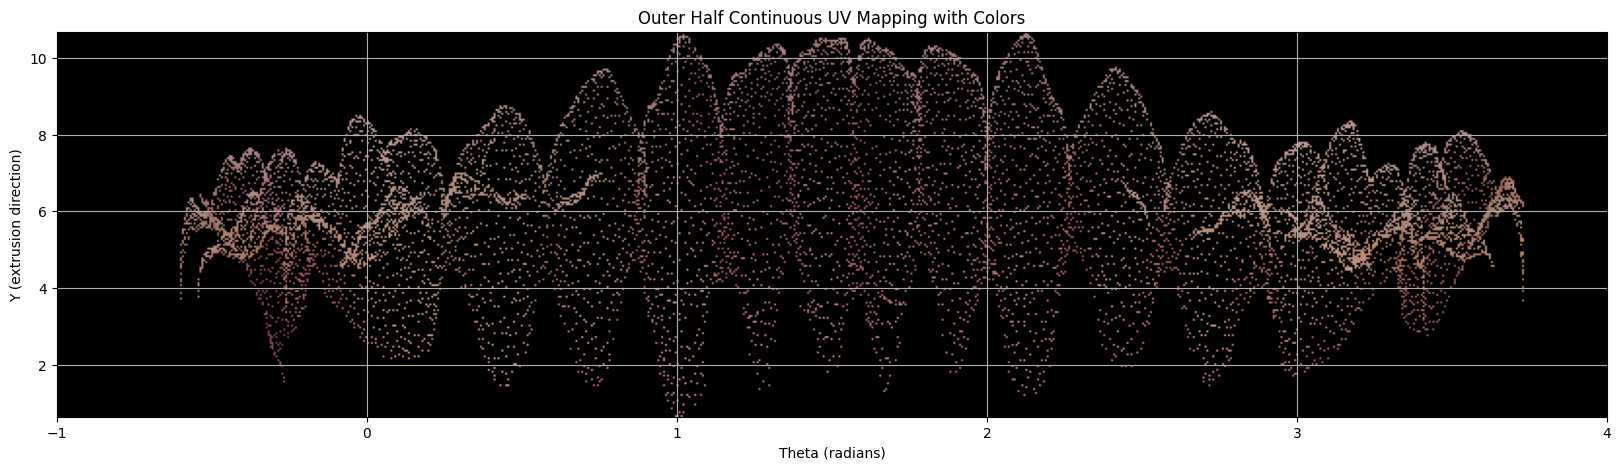

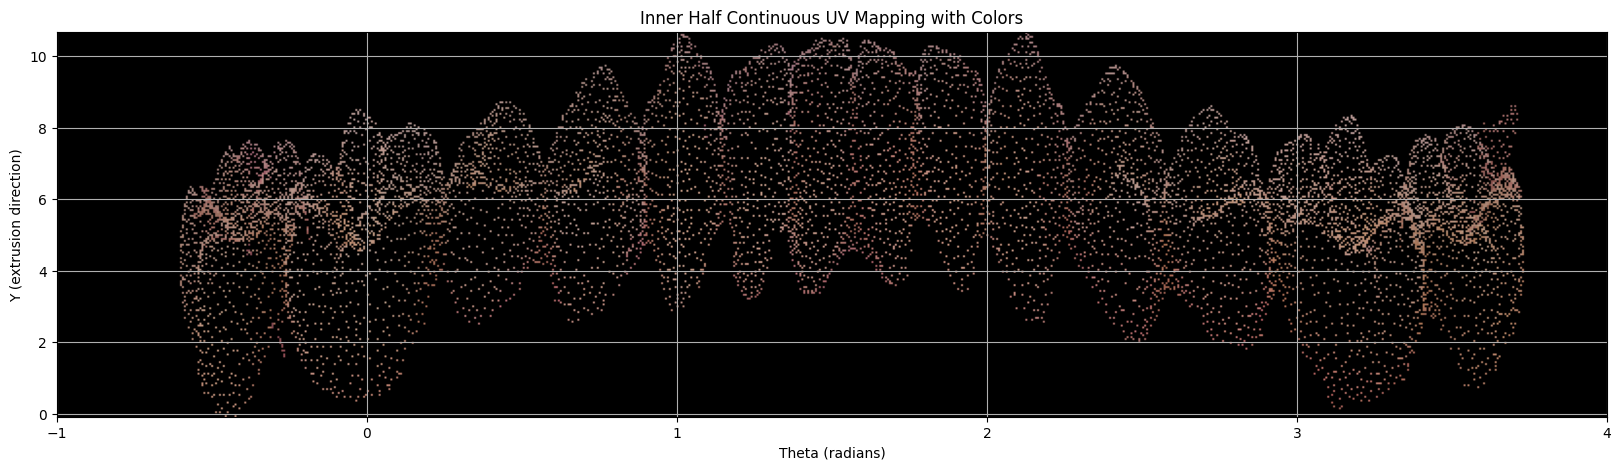

In [76]:
def visualize_continuous_uv_mapping(mesh, uv_coords, colors, title, resolution_theta=1000):
    if uv_coords.size == 0:
        print(f'No UV coordinates to plot for {title}')
        return
    
    # Define the aspect ratio and calculate resolution for y axis
    aspect_ratio = 25 / 5
    resolution_y = int(resolution_theta / aspect_ratio)
    
    # Create a high-resolution grid
    theta_min, theta_max = -np.pi / 2, 3 * np.pi / 2
    y_min, y_max = np.min(uv_coords[:, 1]), np.max(uv_coords[:, 1])
    theta_range = np.linspace(theta_min, theta_max, resolution_theta)
    y_range = np.linspace(y_min, y_max, resolution_y)
    theta_grid, y_grid = np.meshgrid(theta_range, y_range)
    
    # Create an empty image for the colors
    image = np.zeros((resolution_y, resolution_theta, 3))
    counts = np.zeros((resolution_y, resolution_theta))
    
    # Fill the image with mean colors
    for uv, color in zip(uv_coords, colors):
        theta, y = uv
        i = int((theta - theta_min) / (theta_max - theta_min) * (resolution_theta - 1))
        j = int((y - y_min) / (y_max - y_min) * (resolution_y - 1))
        image[j, i] += color
        counts[j, i] += 1
    
    # Normalize the colors by the counts
    valid = counts > 0
    image[valid] /= counts[valid, None]
    
    # Plot the image
    plt.figure(figsize=(20, 5))
    plt.imshow(image, extent=[theta_min, theta_max, y_min, y_max], origin='lower', aspect='auto')
    plt.title(title)
    plt.xlabel('Theta (radians)')
    plt.ylabel('Y (extrusion direction)')
    plt.xlim(-1,4)
    plt.grid(True)
    plt.show()

# Visualize the continuous and filled-in projections with color information
visualize_continuous_uv_mapping(intraoral_mesh, projected_outer_uv, colors_outer, 'Outer Half Continuous UV Mapping with Colors')
visualize_continuous_uv_mapping(intraoral_mesh, projected_inner_uv, colors_inner, 'Inner Half Continuous UV Mapping with Colors')
